# Astros Cheating Scandal: Using Trashcan Data

## Introduction to the Problem

The Astros Cheating Scandal is the biggest MLB scandal to date; the largest punishments ever were given out for the unprofessional behavior and actions of the team in the 2017 and 2018 seasons. Just to recap the scandal for anyone unaware, the Astros used HD cameras to steal the signs the catcher gives the pitcher, along with other methods. The camera feed was livestreamed to their dugout, where they would bang a trash can signaling their hitter what type of pitch would come next (fastball or off-speed). A simple advantage like this can go a huge way in baseball, where the best hitters in the game hit .300 and an average player hits .250. Hitting a baseball at the MLB level is extremely difficult, so every advantage the hitter can get goes a long way. Considering the Astros used this underhanded method during the 2017 season when they won the World Series Trophy, it was hotly debated whether their trophy should be stripped from them. The commisioner decided not to strip away the trophy, but handed out extreme punishments for the club: 

-   Suspended Manager AJ Hinch and General Manager Jeff Luhnow for one year (Astros owner Jim Crane has since fired both)
-   1st and 2nd round picks for 2020 and 2021 were stripped from team entirely
-   Fined $ 5 million, the max amount allowed under MLB Constitution

While no players were directly suspended, the Astros Club is taking a huge setback by losing it's management and losing these draft picks. For more background on the Astros Cheating Scandal, click [here](https://www.si.com/mlb/2020/01/13/houston-astros-cheating-punishment).

## Target and Approach

I'm attempting to predict whether the Astros will cheat during an at bat based on conditions during the game. The data was recorded from auditory trash can banging from the Astros' dugout, signaling whether a fastball or breaking ball was coming, to the batter. While this information is Astros specific, hopefully we can glean more insight into the conditions they would most often cheat so umpires can prepare for potential future scandals.

The data for this problem was taken from [signstealingscandal.com](signstealingscandal.com).

## Initial Data Cleaning

In [728]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [729]:
!pip install category_encoders
!pip install altair

In [730]:
# Read in dataframe. Shape should be (8274, 29)
data = pd.read_csv('https://raw.githubusercontent.com/mtoce/Build2-Project/master/astros_bangs_20200127.csv')
data.shape

(8274, 29)

In [731]:
def wrangle(X):
    '''
    Wrangle function for DF before train_test_split
    '''

    X = X.copy()

    # Change game_date to a datetime to grab month (could be useful in predicting)
    X['game_date'] = pd.to_datetime(X['game_date'], infer_datetime_format=True)
    X['game_month'] = X['game_date'].dt.month

    # Rename target column to make more sense (bangs is banging a trashcan indicating cheating)
    X = X.rename(columns={"has_bangs": "cheats"})

    # Replace some character strings with numbers for ease of use in models
    X['cheats'] = X['cheats'].replace({'n': 0, 'y': 1})
    X['on_1b'] = X['on_1b'].replace({'t': 1, 'f': 0})
    X['on_2b'] = X['on_2b'].replace({'t': 1, 'f': 0})
    X['on_3b'] = X['on_3b'].replace({'t': 1, 'f': 0})

    # Drop these columns since they are video playback related or contain no cardinality
    X = X.drop(columns=['youtube_id', 'pitch_youtube_seconds', 'youtube_url', 
                    'pitch_datetime', 'game_pitch_id', 'event_number', 
                    'pitch_playid', 'atbat_playid', 'bangs', ])

    # Save only data where bangs occured (95% of df), remove the rest
    games_with_bangs_list = X[(X['cheats'] == 1)].game_date.to_list()
    X = X[X['game_date'].isin(games_with_bangs_list)]

    # Remove rows with runners getting out to end the inning (<.2% of outcomes)
    # Since it will conflict with any batting average and obp calculations
    no_interference = ['Home Run', 'Single', 'Strikeout', 'Double Play', 
                   'Grounded Into DP', 'Flyout', 'Groundout', 'Lineout', 'Walk',
                   'Sac Fly', 'Pop Out', 'Double', 'Forceout', 'Field Error', 
                   'Sac Bunt', 'Hit By Pitch', 'Strikeout - DP', 'Triple', 
                   'Fielders Choice Out', 'Bunt Groundout', 'Bunt Pop Out']
    
    # Remove the outliers where the outcome of the batter's AB was interference, giving the runner a base (for batting average calculations)
    X = X[X['at_bat_event'].isin(no_interference)]

    # Drop columns that may contain data leakage (such as the exact day where they may have cheated a lot for no real reason)
    X = X.drop(['game_date', 'game_id', 'call_code'], axis=1)

    return X

df = wrangle(data)

## Feature Engineering

In [732]:
def feature_engineering(X):
  '''
  Engineer new features for dataframe X.
  '''
  X = X.copy()

  # define list for ways batter can get a hit / on_base / out
  hit_list = ['Single', 'Double', 'Triple', 'Home Run']
  obp_list = ['Single', 'Double', 'Triple', 'Home Run', 'Walk', 'Hit By Pitch', 'Sac Fly']
  out_list = ['Strikeout', 'Double Play',
       'Grounded Into DP', 'Catcher Interference', 'Flyout', 'Groundout',
       'Lineout', 'Sac Fly', 'Fan interference', 'Pop Out',
       'Double', 'Forceout', 'Sac Bunt', 'Strikeout - DP', 'Fielders Choice Out',
       'Bunt Groundout', 'Bunt Pop Out']

  # define new features for batter's -At Bat- outcome (AB)
  X['runners_on_base'] = X['on_1b'] + X['on_2b'] + X['on_3b']
  X['batter_hit'] = X['at_bat_event'].isin(hit_list)
  X['batter_base'] = X['at_bat_event'].isin(obp_list)
  X['batter_out'] = X['at_bat_event'].isin(out_list)
  # replace
  X['batter_hit'] = X['batter_hit'].replace({True: 1, False: 0})
  X['batter_base'] = X['batter_base'].replace({True: 1, False: 0})
  X['batter_out'] = X['batter_out'].replace({True: 1, False: 0})                                      
  return X

df = feature_engineering(df)

In [733]:
import altair as alt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

## Exploratory Data Visualizations

In [734]:
# Make new df with needed columns for plot
batter_cheats = df.copy()
batter_cheats['game_date'] = data['game_date']
batter_cheats['game_date'] = pd.to_datetime(batter_cheats['game_date'], infer_datetime_format=True)
batter_cheats['cheats'] = df['cheats'].astype(int)
batter_cheats['opponent'] = df['opponent']
batter_cheats = batter_cheats[batter_cheats['cheats'] == 1]
batter_cheats = batter_cheats[(batter_cheats['game_date'] > '04-03-2017') & (batter_cheats['game_date'] <= '10-06-2017')]
batter_cheats.head()

,game_pk,opponent,final_away_runs,final_home_runs,inning,top_bottom,batter,at_bat_event,pitch_type_code,pitch_category,...,on_2b,on_3b,away_team_id,home_team_id,game_month,runners_on_base,batter_hit,batter_base,batter_out,game_date
261,490133,SEA,3,5,3,bottom,Jose Altuve,Strikeout,KC,BR,...,1,1,136,117,5,2,0,0,1,2017-05-04
302,490133,SEA,3,5,6,bottom,Jose Altuve,Strikeout,KC,BR,...,0,0,136,117,5,0,0,0,1,2017-05-04
309,490133,SEA,3,5,6,bottom,Carlos Beltran,Groundout,KC,BR,...,0,0,136,117,5,1,0,0,1,2017-05-04
338,490133,SEA,3,5,8,bottom,Carlos Beltran,Single,SI,FB,...,0,0,136,117,5,1,1,1,0,2017-05-04
374,490133,SEA,3,5,10,bottom,Yuli Gurriel,Strikeout,SL,BR,...,0,0,136,117,5,1,0,0,1,2017-05-04


In [735]:
# create batter list for color.domain param
batter_list = batter_cheats['batter'].value_counts().index.tolist()
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
            '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', 
            '#17becf', '#b80667', '#07e32b', '#510382', '#874303', 
            '#000000','#cc6060', '#8f98ff', '#ffedb3']
chart = alt.Chart(batter_cheats,
    title = "Astros Sign Stealing by Batter (2017 Season)", 
    width = 600, height = 400).mark_bar().encode(
        alt.X('game_date', title = 'Game Date', 
            axis = alt.Axis(titleFont = "Helvetica Neue")),
        alt.Y('cheats', title = 'Cheating During At-Bat', 
            axis = alt.Axis(titleFont = "Helvetica Neue")),
        alt.Color('batter', title = 'Batter', scale = alt.Scale(
                domain = batter_list,
                range = color_list)),
        tooltip = ['batter', 'opponent', 'pitch_category', 'pitch_type_code', 
        'runners_on_base', 'at_bat_event']).interactive()
# configure titles and axes for graph
chart = chart.configure_title(font="Helvetica Neue", fontWeight="bold", fontSize=24, color='#000000')
chart = chart.configure_axisX(grid=False)
chart = chart.configure_axisY(gridColor="#a3a3a3")
chart = chart.configure_axis(titleColor='#000000', tickColor='#000000', labelColor='#000000', labelFontSize=12, titleFontSize=18, tickCount=12)
#chart.save('cheat_by_batter.html')
chart

alt.Chart(...)

In [736]:
cheats_df = df.copy()
nocheat_df = df.copy()
# make a frame where the batter is cheating
cheats_df = cheats_df[cheats_df['cheats']==1]
# make a frame where the batter is not cheating
nocheat_df = nocheat_df[nocheat_df['cheats']==0]

In [737]:
print('mean batting avg with cheating: ', cheats_df['batter_hit'].sum() / cheats_df['batter_out'].sum())
print('mean batting avg no cheating: ', nocheat_df['batter_hit'].sum() / nocheat_df['batter_out'].sum())
print('mean OBP with cheating: ', cheats_df['batter_base'].sum() / cheats_df['batter_out'].sum())
print('mean OBP no cheating: ', nocheat_df['batter_base'].sum() / nocheat_df['batter_out'].sum())

mean batting avg with cheating:  0.28883495145631066
mean batting avg no cheating:  0.31328158689090124
mean OBP with cheating:  0.4575242718446602
mean OBP no cheating:  0.5148771021992238


In [738]:
# create groupby variables to make future code more legible
c = cheats_df.groupby('batter')
n = nocheat_df.groupby('batter')

# list comprehension for our ordered groupby list of batters
batters = [name for name,unused_df in bat]

In [739]:
# create a df for batting average. groupby batter.
batavg = pd.DataFrame()

# calculate batting avg for cheating and not cheating
batavg['batting_avg_cheats'] = c['batter_hit'].sum() / c['batter_out'].sum()
batavg['batting_avg_nocheats'] = n['batter_hit'].sum() / n['batter_out'].sum()

# calculate batting avg differential from cheating and not cheating
batavg['batting_avg_diff'] =  batavg['batting_avg_cheats'] - batavg['batting_avg_nocheats']

# we need to reset_index to make the batter (index) back into a usable column
batavg = batavg.reset_index()

# sort values by batting avg diff
batavg = batavg.sort_values(by=['batting_avg_diff'], ascending=False)

# rest index again and drop old index column
batavg = batavg.reset_index()
batavg = batavg.drop('index', axis=1)

batavg['sort_order'] = batavg.index
batavg

,batter,batting_avg_cheats,batting_avg_nocheats,batting_avg_diff,sort_order
0,Josh Reddick,0.666667,0.452436,0.214230,0
1,Derek Fisher,0.333333,0.192857,0.140476,1
2,Alex Bregman,0.426966,0.287770,0.139197,2
3,Yuli Gurriel,0.480000,0.346056,0.133944,3
4,Norichika Aoki,0.357143,0.283133,0.074010,4
5,Tyler White,0.400000,0.360656,0.039344,5
6,George Springer,0.265957,0.262525,0.003432,6
7,AJ Reed,0.000000,0.000000,0.000000,7
8,Jose Altuve,0.263158,0.274725,-0.011567,8
9,Jake Marisnick,0.271186,0.294118,-0.022931,9


In [740]:
batting_avg = alt.Chart(batavg, title = "How Cheating Affected Batting Average by Batter", width=600, height=400).mark_bar(color='navy').encode(
    alt.X('batter', title = 'Batter', axis = alt.Axis(titleFont = "Helvetica Neue"), sort = alt.SortField(field='sort_order', order='ascending')),
    alt.Y('batting_avg_diff', title = 'Batting Average Differential', axis = alt.Axis(titleFont = "Helvetica Neue")),
    # alt.Color('batter', title = 'Batter', scale = alt.Scale(
    #         domain = batter_list,
    #         range = color_list)),
)

batting_avg = batting_avg.configure_title(fontSize=20)
batting_avg = batting_avg.configure_axis(labelFontSize=13, titleFontSize=18)
batting_avg

alt.Chart(...)

## Target, Baseline, and Split

In [741]:
# create a features DF (X) without the target
y = 'cheats'
X = df.drop(y, axis=1)

# Let's visualize our target and calculate the baseline model
df[y].value_counts(normalize=True)

0    0.855746
1    0.144254
Name: cheats, dtype: float64

In [742]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, df[y], test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=17) # 0.25 x 0.8 = 0.2

## Make Models and Fit them to Training Data

In [743]:
rf_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SelectKBest(),
    RandomForestClassifier(n_jobs=-1, n_estimators=24),
)

logcv = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    LogisticRegressionCV(),
)

In [744]:
# # Use this for actual hyperparameter tuning
# param_distributions = {
#     'randomforestclassifier__n_estimators': [25],
#     'randomforestclassifier__max_depth': [None, 30, 32, 34, 36],
#     'randomforestclassifier__min_samples_split': [6, 8, 10, 12, 14],
#     'randomforestclassifier__criterion': ['gini', 'entropy'],
#     'randomforestclassifier__min_samples_leaf': [1, 2],
#     'randomforestclassifier__max_leaf_nodes': [None],
#     'randomforestclassifier__oob_score': [True, False],
#     'selectkbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
#     'simpleimputer__strategy': ['most_frequent'],
# }

# Use this for final model (one parameter each)
rf_param_distributions = {
    'randomforestclassifier__n_estimators': [300],
    'randomforestclassifier__max_depth': [32],
    'randomforestclassifier__min_samples_split': [10],
    'randomforestclassifier__criterion': ['entropy'],
    'randomforestclassifier__min_samples_leaf': [2],
    'randomforestclassifier__max_leaf_nodes': [None],
    'randomforestclassifier__oob_score': [True],
    'selectkbest__k': [10],
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=1,
    cv=5,
    scoring='roc_auc',
    verbose=0,
    return_train_score=True,
    random_state=17,
    n_jobs=-1
)

# Fit both models
logcv.fit(X_train, y_train)
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('selectkbest',
                                              SelectKBest(k=10,
                                                          score_func=<function f_classif at 0x00000122C70E6D38>)),
                                             ('rando

## Use Fit Models to Predict Test Data

In [745]:
# Save best model to the pipeline variable
rf_pipeline = rf_search.best_estimator_
# Fit saved best pipeline to X_train
rf_pipeline.fit(X_train, y_train)
# Get predicted target variables
y_pred = rf_pipeline.predict(X_test)
y_pred2 = logcv.predict(X_test)
# y_pred probabilities for ROC_AUC
y_pred_prob = rf_pipeline.predict_proba(X_val)[:, 1]
y_pred_prob2 = logcv.predict_proba(X_val)[:, 1]
#y_pred for baseline is a prediction of 0 for all instances
y_pred_prob3 = [0]*len(y_pred_prob)

## ROC_AUC Score Metric for Models

In [746]:
# run roc_curve on each model and the baseline
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred_prob2)
fpr3, tpr3, thresholds3 = roc_curve(y_val, y_pred_prob3)

# Create DF for ROC_AUC graph in case needed
roc1 = pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds,
    # hacking a legend by using columns from layered chart data
    'Random Forest Classifier': fpr.shape[0] * ['RF-chart']})

roc2 = pd.DataFrame({
    'False Positive Rate': fpr2, 
    'True Positive Rate': tpr2, 
    'Threshold': thresholds2,
    # hack legend #2
    'Logistic Regression': fpr2.shape[0] * ['LR-chart']})

roc3 = pd.DataFrame({
    'False Positive Rate': fpr3, 
    'True Positive Rate': tpr3, 
    'Threshold': thresholds3,
    # hack legend #3
    'Baseline': fpr3.shape[0] * ['BL-chart']})

In [747]:
# declare first chart for layered altair plot (RF model roc-curve)
chart1 = alt.Chart(roc1, title="ROC-AUC Curve for Random Forest and Logistic Regression Models").mark_point(color='#1376a1').encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
    opacity='Random Forest Classifier'
)

# declare second chart for layered altair plot (logcv model roc-curve)
chart2 = alt.Chart(roc2).mark_point(color='#a81365').encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
    shape='Logistic Regression'
)
# declare third chart for layered altair plot (baseline model roc-curve)
chart3 = alt.Chart(roc3).mark_line(color='#e89313', strokeDash=[1,1], ).encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
    size='Baseline'
)
# layer charts and configure title and axes
chart = alt.layer(chart1, chart2, chart3).properties(width=800, height=500)
chart = chart.configure_title(fontSize=20)
chart = chart.configure_axis(labelFontSize=12, titleFontSize=16, tickCount=10)
chart

alt.LayerChart(...)

In [748]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_prob)

print('RF: Best hyperparameters: ', rf_search.best_params_)
print('RF: ROC_AUC_Score', roc_auc_score(y_val, y_pred_prob))
print('Log: ROC_AUC Score: ', roc_auc_score(y_val, y_pred_prob2))

RF: Best hyperparameters:  {'selectkbest__k': 10, 'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__max_depth': 32, 'randomforestclassifier__criterion': 'entropy'}
RF: ROC_AUC_Score 0.9024807513823709
Log: ROC_AUC Score:  0.6906479169662348


## Permutation Importances

In [749]:
# needs to be in separate code cell from block below or won't work properly
plt.rcParams['figure.figsize'] = (25, 15)

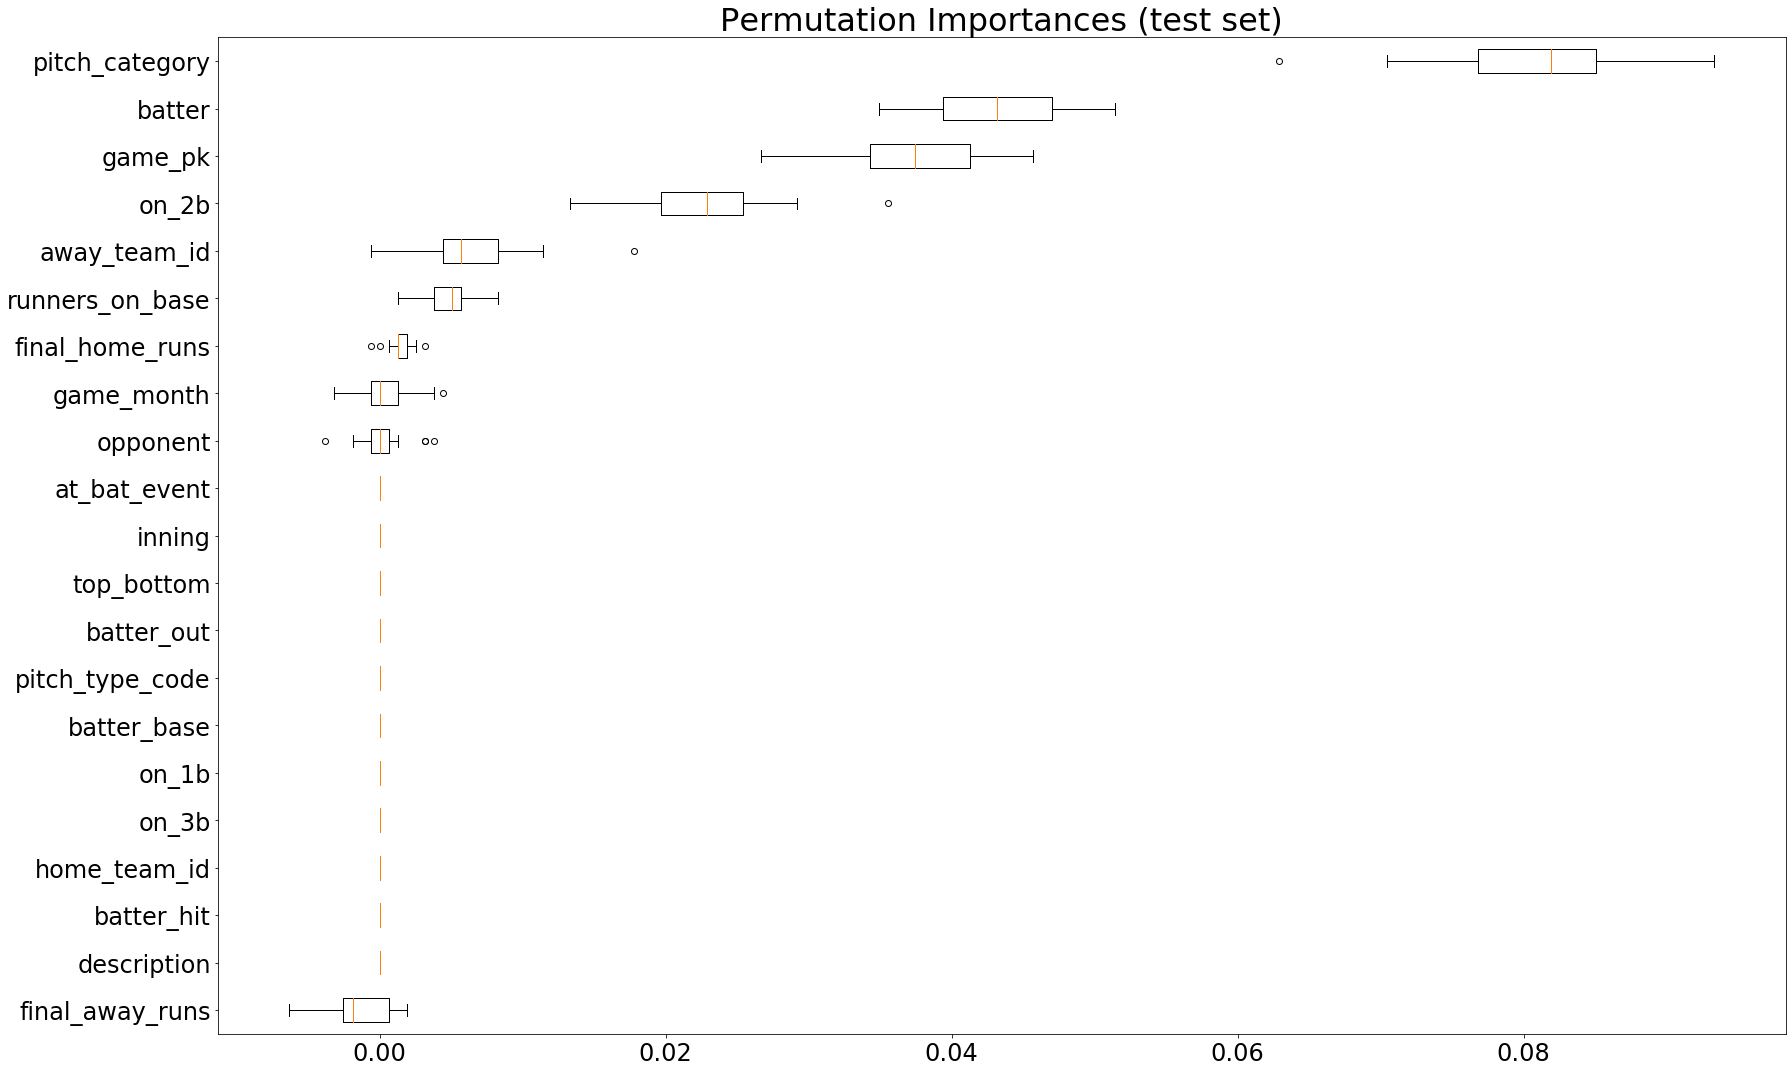

In [754]:
from sklearn.inspection import permutation_importance

# get permutation importances for RF
result = permutation_importance(rf_pipeline, X_test, y_test, n_repeats=25, random_state=17, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()      # gets sorted index from results
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,        # makes boxplot with column headers as labels
           vert=False, labels=X_test.columns[sorted_idx])
ax.tick_params(labelsize=24)
ax.set_title("Permutation Importances (test set)", size=32)
fig.tight_layout()
plt.savefig('permutation_importances.png')
plt.show()

## Confusion Matrix, Precision and Recall

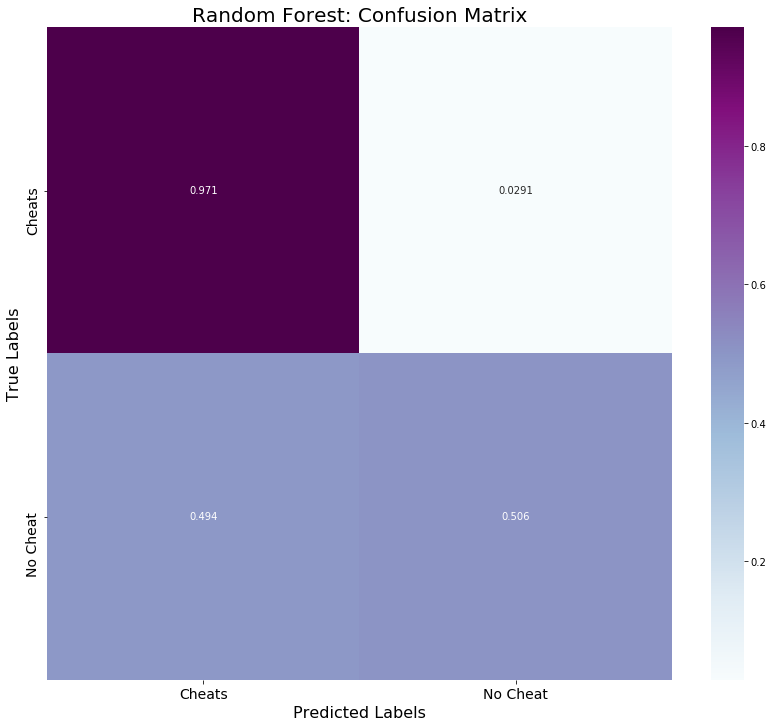

In [751]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(14,12))    # Sample figsize in inches
sns.heatmap(cm_norm, annot=True, ax = ax, fmt='.3g', cmap="BuPu"); #annot=True to annotate cells
labels = ['Cheats', 'No Cheat']
# opp_labels = ['Passed Inspection', 'Failed Inspection']
# labels, title and ticks
ax.set_xlabel('Predicted Labels', color='k', size=16)
ax.set_ylabel('True Labels', color='k', size=16)
ax.set_title('Random Forest: Confusion Matrix', color='k', size=20)
ax.xaxis.set_ticklabels(labels, color='k', size=14)
ax.yaxis.set_ticklabels(labels, color='k', size=14)
#plt.savefig('cmatrix.png')
plt.show()

In [752]:
tp = cm[0][0]       # true positives
fn = cm[0][1]       # false negatives
fp = cm[1][0]       # false positives
tn = cm[1][1]       # true negatives
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('RF Model - Precision: ', precision)
print('RF Model - Recall: ', recall)

RF Model - Precision:  0.9173728813559322
RF Model - Recall:  0.9708520179372198


In [753]:
cm2 = confusion_matrix(y_test, y_pred2)
tp = cm2[0][0]       # true positives
fn = cm2[0][1]       # false negatives
fp = cm2[1][0]       # false positives
tn = cm2[1][1]       # true negatives
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('LR Model - Precision: ', precision)
print('LR Model - Recall: ', recall)

LR Model - Precision:  0.8495238095238096
LR Model - Recall:  1.0
